This notebook is dedicated to explortory data anlysis on the normalised dataset after feature extraction.

It covers the following:
*   Loading raw data into a single aggregated dataframe 
*   Apply feature extraction and normalisation
*   Performing various EDA tasks on the resulting dataframe

In [1]:
# import libraries
from os import path, listdir
import numpy as np
import pandas as pd
import seaborn 
import matplotlib

In [15]:
# This script loads the source datasets and produces a single joint pandas dataframe
# it also applies feature extraction and normalisation to the data

# display all columns in the dataset when printing (e.g. head())
pd.set_option('display.max_columns', None)

def load_sentiment_data():
    data = pd.read_csv("./data/Combined_News_DJIA.csv",usecols=['Date','Label'])
    
    # Set Date as index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Rename column
    data.columns = ['Sentiment']
    return data


def load_spx_data():
    data = pd.read_csv("./data/spx.csv")
    
    # Set Date as index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Rename column
    data.columns = ['SPX_Close']

    # Relative change features
    data["SPX_Close"] = data["SPX_Close"].pct_change()

    return data


# General method for loading Stock/ETF data from many .txt sources in a directory
def load_txts(dir_path, ctr):
    # Load the data for multiple .txt files
    data = []
    csv_paths = [dir_path+x for x in listdir(dir_path) if x.endswith('.txt') and path.getsize(dir_path+x) > 0]
    for file_path in csv_paths:
        df = pd.read_csv(file_path, usecols=['Date','Open','High','Low','Close','Volume'])
        # Add 'Ticker' for the Stock/ETF as feature
        #df['Ticker'] = file_path.replace(dir_path,'').replace('.txt', '')
        df['Ticker'] = ctr
        ctr += 1
        data.append(df)
    data = pd.concat(data, ignore_index=True)
    data.reset_index(inplace=True, drop=True)
    
    # Set Date as index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Relative change features
    data["Open"] = data["Open"].pct_change()
    data["Close"] = data["Close"].pct_change()
    data["High"] = data["High"].pct_change()
    data["Low"] = data["Low"].pct_change()
    data["Volume"] = data["Volume"].pct_change()
    return (ctr, data)


# Filter rows that are no in the time range from a time series dataframe
def filter_by_time(df):
    return df.sort_index().loc['2008-09-01':'2016-07-01']


# Load initial data
sentiment = load_sentiment_data()
spx = load_spx_data()
c, stocks = load_txts('./data/Stocks/', 0)
c, etfs = load_txts('./data/ETFs/', c)

# Filter sentiment adn spx dataframes by time
sentiment = filter_by_time(sentiment)
spx = filter_by_time(spx)

# Join the datasets into a single dataframe "result"
stock_etf_df = pd.concat([etfs, stocks])
stock_etf_df = filter_by_time(stock_etf_df)
sentiment_labeled_df = stock_etf_df.join(sentiment, how="outer")
result = sentiment_labeled_df.join(spx, how="outer")

In [16]:
# drop non-numerical values
result = result.replace([np.inf, -np.inf], np.nan).dropna()

In [17]:
# apply Z-normalisation
normalised_result = result.copy()

columns = ['Open','Close','High','Low','Close','Volume','Sentiment','SPX_Close']
for c in columns:
  normalised_result[c] = (normalised_result[c]-normalised_result[c].mean())/normalised_result[c].std()

In [18]:
print(normalised_result.describe())

               Open          High           Low         Close        Volume  \
count  1.022181e+07  1.022181e+07  1.022181e+07  1.022181e+07  1.022181e+07   
mean   9.529900e-16  1.654237e-15 -8.568433e-16  1.473696e-16  6.782016e-17   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.634815e-03 -2.465120e-03 -2.663523e-03 -2.565992e-03 -2.276643e-03   
25%   -4.757033e-04 -4.631358e-04 -4.555661e-04 -4.519282e-04 -1.674400e-03   
50%   -4.533493e-04 -4.454356e-04 -4.357042e-04 -4.311271e-04 -1.385771e-03   
75%   -4.304992e-04 -4.287613e-04 -4.153315e-04 -4.097930e-04 -9.427570e-04   
max    3.032715e+03  3.056634e+03  3.062554e+03  3.071663e+03  3.160052e+03   

             Ticker     Sentiment     SPX_Close  
count  1.022181e+07  1.022181e+07  1.022181e+07  
mean   4.332930e+03 -1.228065e-12  6.607008e-13  
std    2.507437e+03  1.000000e+00  1.000000e+00  
min    0.000000e+00 -1.071726e+00 -7.055598e+00  
25%    2.113000e+03 -1.071726e+00 -3.7

In [19]:
# Basic EDA on the result df
print(result.head()) 
print(result.shape)
print(result.info())
print(result.describe())

                Open      High       Low     Close    Volume  Ticker  \
Date                                                                   
2008-09-02  0.002406 -0.027174 -0.005615 -0.005615 -0.540947     474   
2008-09-02  0.022886  0.045758  0.027203  0.036847  0.925269    6936   
2008-09-02  0.005627  0.026327  0.037480  0.027506  0.830504    2533   
2008-09-02 -0.020137 -0.016573 -0.025445 -0.024176  0.266096    3777   
2008-09-02 -0.012893  0.005794  0.000726  0.007873  0.374273    6525   

            Sentiment  SPX_Close  
Date                              
2008-09-02        0.0  -0.004093  
2008-09-02        0.0  -0.004093  
2008-09-02        0.0  -0.004093  
2008-09-02        0.0  -0.004093  
2008-09-02        0.0  -0.004093  
(10221814, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10221814 entries, 2008-09-02 to 2016-07-01
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Open       float64
 1   High       float64
 2   Low    

                   Open      High           Low     Close        Volume  \
Open       1.000000e+00  0.999680  9.993682e-01  0.999013  5.620245e-07   
High       9.996796e-01  1.000000  9.998348e-01  0.999730  1.276292e-06   
Low        9.993682e-01  0.999835  1.000000e+00  0.999946  4.169018e-07   
Close      9.990127e-01  0.999730  9.999457e-01  1.000000  1.204353e-06   
Volume     5.620245e-07  0.000001  4.169018e-07  0.000001  1.000000e+00   
Sentiment -2.495887e-04 -0.000257 -2.592330e-04 -0.000257  2.985378e-04   
SPX_Close -1.869198e-04 -0.000186 -1.760787e-04 -0.000171  1.968185e-04   

           Sentiment  SPX_Close  
Open       -0.000250  -0.000187  
High       -0.000257  -0.000186  
Low        -0.000259  -0.000176  
Close      -0.000257  -0.000171  
Volume      0.000299   0.000197  
Sentiment   1.000000   0.622678  
SPX_Close   0.622678   1.000000  


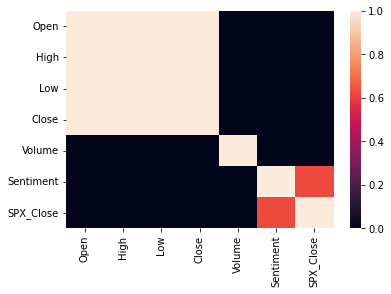

In [14]:
# This block prints the correlation table and heatmap for result df
print(result.corr())

seaborn.heatmap(result.corr());

<AxesSubplot:>

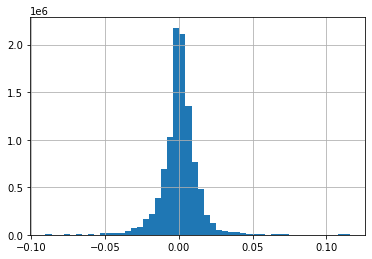

In [15]:
result.SPX_Close.hist(bins=50)

<AxesSubplot:>

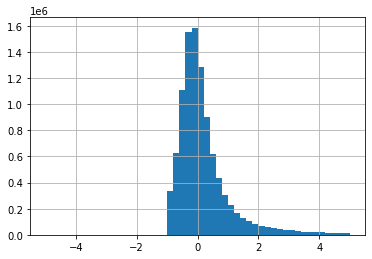

In [16]:
result.Volume.hist(bins=50,range=(-5,5))

<AxesSubplot:>

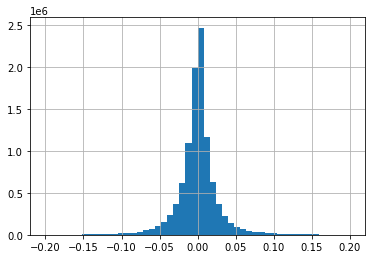

In [17]:
result.Close.hist(bins=50,range=(-0.2,0.2))

<AxesSubplot:>

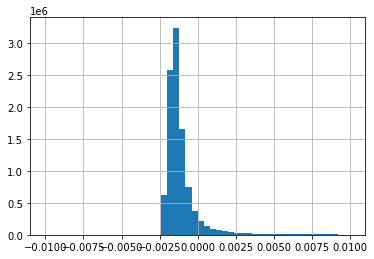

In [18]:
normalised_result.Volume.hist(bins=50,range=(-0.01,0.01))

In [20]:
normalised_result.to_csv('./data/normalised_result.csv')